# Interactive Exploration of Ray Tracing in Julia
> Summary

- toc: true 
- badges: true
- hide_binder_badge: true
- hide_colab_badge: true
- comments: true
- categories: ["ray tracing"]
- image: https://en.wikipedia.org/wiki/Ray_tracing_(graphics)#/media/File:Recursive_raytrace_of_a_sphere.png
- hide: true
- search_exclude: true
- permalink: /ray_tracing/

# Introduction

What is ray tracing? 
> Ray tracing is a rendering technique that can produce incredibly realistic lighting effects. Essentially, an algorithm can trace the path of light, and then simulate the way that the light interacts with the virtual objects it ultimately hits in the computer-generated world. [Source](https://www.techradar.com/au/news/ray-tracing#:~:text=Ray%20tracing%20is%20a%20rendering,in%20the%20computer%2Dgenerated%20world.)



## Running This Notebook

This blog post was made entirely in a Jupyter Notebook so you can download it (link to GitHub at top of post) and run it for yourself. I chose to write in Julia as opposed to Python for a number of reasons:
- Julia is compiled and runs as almost as fast as C
- Interactive and can be used in a Jupyter Notebook (the Ju in Jupyter stands for Julia after all)
- Built for parallel computing, GPU computing, and shared memory computing
- Supports mathematical symbols in code
- Rather similar to use for someone used to `numpy`
- I'm learning Julia right now and the best way to learn a new programming language is to use it!


I want to try using BibTeX in my blog posts (default is APA). Here is a test...

Test BibTeX citation {% cite rew_netcdf_1990 %}



# Setup

![](https://yiweimao.github.io/blog/images/2020-06-14-6sv_files/6sv_vermote.png){:width="70%"}


We need to model 
1. Light propagation
    - Timestepping: useful for clouds/smoke, or in our case, an atmosphere with changing refractive index
    - Event driven: traditional approach. only recompute on interaction with a surface
2. Reflection
3. Refraction








## Defining Types and Functions

Let's first define a `Ray` type which has attributes:
- a velocity (or propagation direction)
- a position vector

It is mutable so we can use in-place operations on it. 

In [1]:
mutable struct Ray
    v̅::Vector{Float64} # velocity vector
    x̅::Vector{Float64} # position vector
    # c::RGB             # colour
    # the alpha channel can deal with reflection/refraction splitting into two rays (recursive step)
end

Let's now define a `FlatSurface`. Other interesting easy to model surfaces are spheres. We can also model partial reflection and refraction.

In [2]:
abstract type Surface end

"""
The equation for a plane ax+by+cz+d=0
is given by the normal n̂=(a,b,c) and
a point x̅=(x,y,z)
"""
struct FlatSurface <: Surface
    n̂::Vector{Float64} # normal vector
    x̅::Vector{Float64} # position
    # n::Float64         # refractive index
    # the reflectivity and transmittivity can be calculated by the refractive index
end

struct SphereSurface <: Surface
    r::Float64         # radius
    x̅::Vector{Float64} # centre point
    #n::Float64        # refractive index
end

And work out how to draw these surfaces

In [3]:
using PyPlot

function drawSurface(s::FlatSurface,bbox::Array=[0,-10,-1,10,10,10])
    # since we are drawing on x-z plane, ⟂ vector is ±(-nz,0,nx)
    x_perp = [-s.n̂[3],0,s.n̂[1]]
    x_perp ./= norm(x_perp)
    
    bbox_r = norm([bbox[4]-bbox[1],bbox[5]-bbox[2],bbox[6]-bbox[3]])
    p₁ = s.x̅ .- bbox_r.*x_perp
    p₂ = s.x̅ .+ bbox_r.*x_perp
    
    plt.plot([p₁[1],p₂[1]],[p₁[3],p₂[3]],"-k")
    plt.axis("equal")
    
    bbox = [bbox[1],bbox[4],bbox[3],bbox[6]]
    plt.axis(bbox)
end

function drawSurface(s::SphereSurface,bbox::Array=[-1,-10,-1,10,10,10])
    #y = 0 # drawing on a x-z plane
    plt.gcf().gca().add_artist(plt.Circle((s.x̅[1],s.x̅[3]), s.r, fill=false))
    plt.axis("equal")
    
    bbox = [bbox[1],bbox[4],bbox[3],bbox[6]]
    plt.axis(bbox)
end

drawSurface (generic function with 4 methods)

Now I create a reflect function that modifies the ray's direction in place

> Important: The ! symbol means the function can operate on the arguments *in-place*. As opposed to working on a copy.

In [4]:
function reflect!(ray::Ray,n̂::Vector{Float64})
    ray.v̅ .= ray.v̅ .- 2*dot(ray.v̅,n̂).*n̂
    #x̅ = ⟶.x̅ .+ 0.001.*⟶.x̅
    #return Ray(v̅, ⟶.x̅)
end

reflect! (generic function with 1 method)

And now we have two intersect functions that work in place

> Tip: This is an example of Julia's multiple dispatch feature. It's really powerful!

In [5]:
using LinearAlgebra

"""
check if ray is travelling towards a surface, and if so, reflect it
"""
function intersect!(ray::Ray,s::FlatSurface)
    if dot(ray.v̅,s.n̂) < 0 && dot(ray.x̅,s.n̂) ≤ dot(s.x̅,s.n̂)
        reflect!(ray,s.n̂)
        # and refract
    end
end

function intersect!(ray::Ray,s::SphereSurface)
    r̅ = ray.x̅-s.x̅
    if dot(ray.v̅,r̅) < 0 && norm(r̅) ≤ s.r
        reflect!(ray,r̅/norm(r̅))
        # and refract
    end
end

intersect! (generic function with 2 methods)

work out how to propagate the rays

In [6]:

function propagate!(ray::Ray, s::Surface, Δt::Float64)
    intersect!(ray,s)
    ray.x̅ .+= ray.v̅*Δt # divide by refractive index
end


propagate! (generic function with 1 method)

## Flat Mirror

Now to put it all together and plot the ray path as it hits a mirror

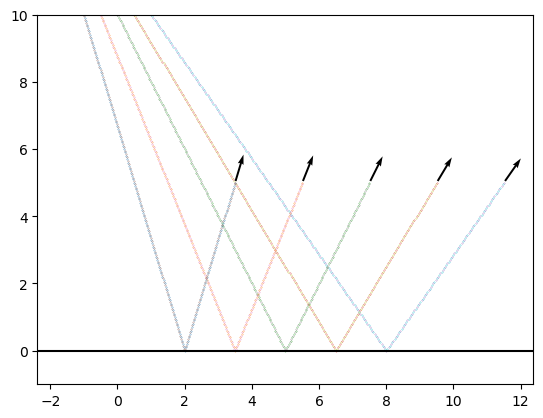

In [11]:
s = FlatSurface([0,0,1],[0,0,0])

rays = [ Ray([0.5+0.2*i,0,-1],[i,0,10]) for i ∈ -1:0.5:1 ]

Δt = 0.05 # s
T = 15 # s

drawSurface(s)

for dt in 0:Δt:T
    for ray in rays
        #quiver(ray.x̅[1],ray.x̅[3],ray.v̅[1],ray.v̅[3],headaxislength=0,headlength=0,width=1e-4)
        scatter(ray.x̅[1],ray.x̅[3],s=5e-2)
        propagate!(ray,s,Δt)
    end
end

for ray in rays
    quiver(ray.x̅[1],ray.x̅[3],ray.v̅[1],ray.v̅[3],width=4e-3)
end

that took about 10 seconds

## Spherical Mirror
Time to test ray tracing for a sphere target

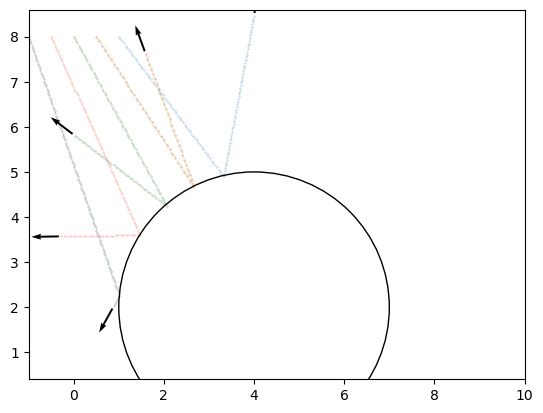

In [10]:
s = SphereSurface(3,[4,0,2])

rays = [ Ray([0.55+0.2*i,0,-1],[i,0,8]) for i ∈ -1:0.5:1 ]

Δt = 0.05 # s
T = 6 # s

drawSurface(s)

for dt in 0:Δt:T
    for ray in rays
        #quiver(ray.x̅[1],ray.x̅[3],ray.v̅[1],ray.v̅[3],headaxislength=0,headlength=0,width=1e-4)
        scatter(ray.x̅[1],ray.x̅[3],s=5e-2)
        propagate!(ray,s,Δt)
    end
end

for ray in rays
    quiver(ray.x̅[1],ray.x̅[3],ray.v̅[1],ray.v̅[3],width=4e-3)
end

that took 4 seconds...


> Warning: None of this was optimised for parallel computing!


- Now think about plotting this in 3D. 
- Add transparent materials with different refractive indicies. 
- Deal with coloured spheres (ray will have a RGBA value) and 
- could be possible to do a BRDF.

$~$

**This is a fun side project to get me understanding how to write Julia code!**


# References

{% bibliography --cited %}

In [9]:
#hide

# copy of some code using MIT18S191

struct Camera
    pixels
    
    size::Vector{Float64} # of aperture in physical dimensions
    
    f::Float64 # focal length 
    
    p::Vector{Float64} # camera position
    
end

# ⟿ x

struct Ray
    v::Vector{Float64} # velocity vector
    p::Vector{Float64} # position vector
    c::RGB             # colour
end

struct Surface
    r::Float64 # reflectivity
    t::Float64 # transmittivity
    c::RBGA    # colour
    n::Float64 # refractive index
    
    # inner constructor
    function Surface(r_in, t_in, c_in, n_in)
        if !isapprox(r_in+t_in+c_in.alpha, 1)
            error("invalid surface definition, r+t+c.alpha < 1")
        end
        new(r_in,t_in,c_in,n_in)
    end
    
    Surface(r_in, t_in, c_in::Float64, n_in) = 
        new(r_in,t_in,RGBA(0,0,0,0),n_in)
end
    
abstract type Object end

struct Sphere <: Object
    p::Vector{Float64} # position
    r::Float64         # radius
    s::Surface
end

ClearSphere(p,r,n) = Sphere(p,r,Surface(0,1,RGBA(0,0,0,0),n))
ReflectSphere(p,r) = Sphere(p,r,Surface(1,0,RGBA(0,0,0,0),0))
ColourSphere(p,r,c::RGB) = Sphere(p,r,Surface(0,0,RGBA(c),0))


struct SkyBox <: Object
    p::Vector{Float64} # position
    r::Float64         # radius
end



sphere_normal_at(ray,sphere) = normalize(ray.p .- sphere.p)



LoadError: invalid redefinition of constant Ray